<a href="https://colab.research.google.com/github/PhiCtl/Flower_detection/blob/main/Object_detection_FRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Acknowledgments 
* **TorchVision 0.3 Object Detection finetuning tutorial** : https://github.com/pytorch/vision/tree/master/references/detection, https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

# What this notebook allows
1. To train the following neural networks :
    * Faster-RCNN with ResNet50, MobileNetV3 large FPN and MobileNetV3 large FPN 320 (low-resolution) backbones
    * Mask-RCNN with ResNet50 backbone
2. To visualize their predictions
3. To evaluate their performance
4. To load a model and make inference

# 1. Training

### When the folders get messy

In [ ]:
%%shell
cd
cd /content/ # cd whatever
rm -r Flower_detection

## A) Upload necessary git repositories and packages

For Torchvision training tutorial

In [1]:
%%shell
pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-hoygr510
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-hoygr510
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263905 sha256=a19959c65013879437c41a29f1cccda771c48c8f3451d013a375e6537ea07b58
  Stored in directory: /tmp/pip-ephem-wheel-cache-xt7fc1pw/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [2]:
%%shell
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 27442, done.
remote: Counting objects: 100% (5050/5050), done.
remote: Compressing objects: 100% (1260/1260), done.
remote: Total 27442 (delta 3909), reused 4724 (delta 3698), pack-reused 22392
Receiving objects: 100% (27442/27442), 35.43 MiB | 26.38 MiB/s, done.
Resolving deltas: 100% (20489/20489), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


For my repository

In [3]:
%%shell
# My own repo
git clone https://github.com/PhiCtl/Flower_detection.git
cd Flower_detection/src
cp myClasses.py ../../
cp myTransforms.py ../../
cp myUtils.py ../../
cp myTrainingUtils.py ../../

Cloning into 'Flower_detection'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (288/288), done.
remote: Total 384 (delta 252), reused 164 (delta 89), pack-reused 0
Receiving objects: 100% (384/384), 11.91 MiB | 11.83 MiB/s, done.
Resolving deltas: 100% (252/252), done.


For the metrics tool-kit

In [ ]:
%%shell
# ref https://github.com/rafaelpadilla/Object-Detection-Metrics#how-to-use-this-project
git clone https://github.com/rafaelpadilla/Object-Detection-Metrics.git

Credits to R. Padilla et al, A Comparative Analysis of Object Detection Metrics with a Companion Open-Source Toolkit, Electronics, 2021,
https://www.mdpi.com/2079-9292/10/3/279


## B) Imports

In [1]:
import numpy as np
from torch.utils.data import DataLoader
import torchvision, cv2, time, copy
import torchvision.transforms as T
import torch.functional as F

from myTransforms import get_img_transformed 
from myUtils import*
from myClasses import *
from myTrainingUtils import*

from engine import train_one_epoch, evaluate
import utils

################################################################################
# GETTING STARTED
################################################################################

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


## C) Load data

### To download the masks
1. Specify the path to json label file
2. Specify the path where the masks will be stored

In [6]:
path_json = # TODO fill in
path_masks = # TODO fill in
download_masks(path_json, path_masks)

In case it didn't work, specify manually the picture name.

In [ ]:
url_list = parseURLJSON(path_train)
val = url_list['P1040790.JPG']
p = '/content/drive/MyDrive/GBH/data_train/masks'
path = os.path.join(p, 'P1040790.JPG')
os.mkdir(path)
for i, url in enumerate(val):
  file_name = path + "/" + str(i) + ".jpg"
  urllib.request.urlretrieve(url, file_name)


### Defining Transforms

In [2]:
myTransform = None # rescale or rotate
transforms_train = T.Compose([T.ToTensor(), T.ColorJitter(0.1, 0.1), T.Normalize(mean=MEAN_Imagenet, std= STD_Imagenet)])
transforms_test = get_img_transformed(train=False)

### Load train and test datasets

In [3]:
################################################################################
# LOAD BBOX ONLY DATASETS        
################################################################################

dataset = FlowerDetectionDataset('/content/drive/MyDrive/GBH/data_train/images_raw', json_file_root='/content/drive/MyDrive/GBH/labels/export1m.json', custom_transforms=None, transforms=transforms_train)
data_loader = DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

dataset_test = FlowerDetectionDataset('/content/drive/MyDrive/GBH/data_test/images', json_file_root='/content/drive/MyDrive/GBH/labels/export2m.json', transforms=transforms_test)
data_loader_test = DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [4]:
################################################################################
# LOAD MASKS DATASETS      
################################################################################

dataset = FlowerMaskDetectionDataset(root_img = '/content/drive/MyDrive/GBH/data_train/images_raw/', root_masks =  '/content/drive/MyDrive/GBH/data_train/masks/', custom_transforms=None, transforms=transforms_train)
data_loader = DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

dataset_test = FlowerMaskDetectionDataset(root_img = '/content/drive/MyDrive/GBH/data_test/images/', root_masks = '/content/drive/MyDrive/GBH/data_test/masks/', transforms=transforms_test)
data_loader_test = DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [12]:
dataset = FlowerDetectionDataset('/content/drive/MyDrive/GBH/final_test/images/', json_file_root='/content/drive/MyDrive/GBH/final_test/label_test.json', custom_transforms=None, transforms=transforms_test)
data_loader = DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)


### Test if dataset class is doing well

In [ ]:
img, target = dataset_test[0]
target['scores'] = target['labels']
draw_bboxes(target, dataset_test.imgs[0])

## D) Training

### Built in training

In [5]:
################################################################################
# TRAINING
################################################################################
# if training again a pretrained model
already_trained = False
# weights_path = # TODO fill in

model_type = 'MaskRCNN'

# define model
model = get_object_detection_model(2, model_type) # 3 if includes cores

if already_trained:
  model.load_state_dict(torch.load(weights_path, map_location=device))
  
# move model to device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [6]:
# let's train it for 10 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/47]  eta: 0:21:48  lr: 0.000114  loss: 5.6896 (5.6896)  loss_classifier: 0.5486 (0.5486)  loss_box_reg: 0.1443 (0.1443)  loss_mask: 4.8330 (4.8330)  loss_objectness: 0.1358 (0.1358)  loss_rpn_box_reg: 0.0279 (0.0279)  time: 27.8311  data: 25.0182  max mem: 4303
Epoch: [0]  [10/47]  eta: 0:06:59  lr: 0.001199  loss: 1.7403 (2.7046)  loss_classifier: 0.2271 (0.2916)  loss_box_reg: 0.1220 (0.1446)  loss_mask: 0.9406 (1.8540)  loss_objectness: 0.1885 (0.3764)  loss_rpn_box_reg: 0.0176 (0.0379)  time: 11.3255  data: 8.5617  max mem: 4646
Epoch: [0]  [20/47]  eta: 0:05:01  lr: 0.002285  loss: 1.4068 (1.9923)  loss_classifier: 0.1353 (0.2176)  loss_box_reg: 0.0892 (0.0997)  loss_mask: 0.7534 (1.3002)  loss_objectness: 0.2165 (0.3433)  loss_rpn_box_reg: 0.0192 (0.0315)  time: 10.3312  data: 7.5786  max mem: 4685
Epoch: [0]  [30/47]  eta: 0:03:09  lr: 0.003371  loss: 1.1074 (1.7051)  loss_classifier: 0.1146 (0.1922)  loss_box_reg: 0.0567 (0.0995)  loss_mask: 0.6501 (1.0785)  los

# 2. Visualize Results

## A) Pick one example on test set and draw predictions

For Faster-RCNN

In [ ]:
# pick one image from the test set
img, target = dataset_test[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
draw_bboxes(prediction[0], name=dataset_test.imgs[target['image_id']],thresh=0.5)

For Mask RCNN

In [ ]:
# conf
conf = 0.5

for mask, score in zip(pred[0]['masks'], pred[0]['scores']):
  mask_img = mask.squeeze(0).detach().cpu().numpy()*255
  if score > conf :
    cv2_imshow(mask_img)

# 3.Evaluate model on validation set

## A) Write predictions and groundtruth to file for metrics computation
1. Specify the model type and the weight path
2. Load the model
3. Make predictions (use write_heavy for Mask RCNN, otherwise it will raise memory errors)
4. Write predictions to /detections/ folder (the path can be changed) and groundtruths to /groundtruths.

In [13]:
model_type = 'Resnet50_FPN'
num_classes = 2
weights_path = '/content/drive/MyDrive/GBH/models/07062021_1520.pt'

In [ ]:
# Get model
model = get_object_detection_model(num_classes, model_type)
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
model.eval()

In [20]:
# Make predictions MUSTN'T BE USED WITH MASK RCNN
model.eval()
predictions = eval_custom(dataset_test, model, device=torch.device('cpu'))
# write both predictions and GT
write(dataset_test, predictions, gt=True)

In [20]:
# For Mask RCNN
write_heavy(dataset, model, torch.device('cpu'))

In [18]:
write(dataset, gt=True)

## B) Evaluate on test set
1. specify the folder to record the results
2. launch the following script

In [ ]:
%%shell
mkdir /content/drive/MyDrive/GBH/results/plots_FRCNNResnet50_07062021/
cd Object-Detection-Metrics/
python pascalvoc.py  -gt /content/drive/MyDrive/GBH/results/groundtruths/ -det /content/drive/MyDrive/GBH/results/detections/ -gtformat xyrb -detformat xyrb -sp /content/drive/MyDrive/GBH/results/plots_FRCNNResnet50_07062021/

## C) Save model to disk
1. Change model name (date_time.pt)

In [10]:
weights_name = '07062021_1520.pt' # TODO change
torch.save(model.state_dict(),weights_name)

In [11]:
%%bash
cp 07062021_1520.pt /content/drive/MyDrive/GBH/models/

# 4. Inference

## A) Download model

In [ ]:
# Download a given picture and apply transforms
file_name =  '/content/drive/MyDrive/GBH/final_test/images/pic8_RGB.jpg'
img = cv2.imread(file_name)
# convert to RGB and apply transforms
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = T.Compose([T.ToTensor(), T.Normalize(mean=MEAN_Imagenet, std= STD_Imagenet)])
img = transform(img)

In [ ]:
# Get model
model_name = 'Resnet50_FPN' # TODO : change model name
weights_path = '/content/drive/MyDrive/GBH/models/09052021_1615.pt' # TODO change path
model = get_object_detection_model(2, 'Resnet50_FPN')
device = torch.device('cpu')
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

## B) Evaluate running time on CPU

In [ ]:
# Evaluate and compute running time
it = 5
model.eval()
times = 0
img = img.to(torch.device('cpu'))
for i in range(it):
  t1 = time.time()
  pred = model([img])
  times += (time.time()-t1)
print("time to test: {} s".format(times/it))


time to test: 1.7694642066955566 s


## C) Show prediction

In [ ]:
# Show mask if Mask RCNN
# confidence score
conf = 0.25

for mask, score in zip(pred[0]['masks'], pred[0]['scores']):
  mask_img = mask.squeeze(0).detach().cpu().numpy()*255
  if score > conf :
    cv2_imshow(mask_img)

In [ ]:
import math
def draw_bboxes(image, img_name, target, path ='/content/drive/MyDrive/GBH/final_res/', thresh = 0.3):
    for [xm,ym,xM,yM], label, score in zip(target["boxes"], target["labels"], target["scores"]):
      color = ()
      font = cv2.FONT_HERSHEY_SIMPLEX
      if label == 1: c = (255,0,0)
      if label == 2: c = (0,255,0)
      if score > thresh :
        image = cv2.rectangle(image, (xm,ym), (xM,yM), c, 2)
        image = cv2.putText(image, str(math.trunc(score.item() * 100)) + '%', (xm,yM), font, 0.35, c, 1, cv2.LINE_AA )
    path += img_name
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)
    cv2_imshow(image) ## This line works only for Colab usage

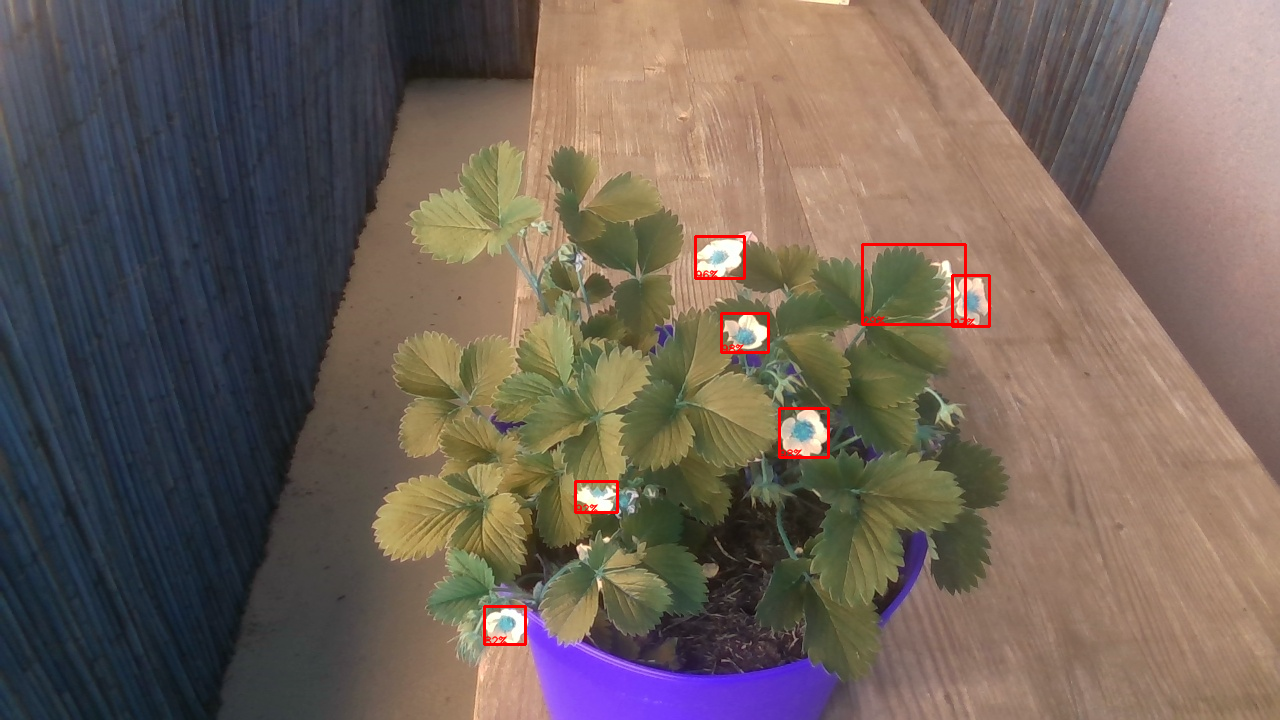

In [ ]:
# convert from torch tensor to open CV conventions
img = img.numpy().transpose(1,2,0)
conf = 0.25
draw_bboxes(img, 'pic3_RGB.jpg', pred[0], thresh=conf)